### Probabilistic Graphical Model - Inpainting Experiment with disentagled CVAE
**Author:** Felipe Cortes Jaramillo

**Description:** We want to do in-painting with the data from the "MLDM-Project", using a disentangled CVAE.

**Idea:** A common approach to encourage disentanglement in VAEs is to modify the Kullback-Leibler (KL) divergence term in the loss function, often by weighing it differently. This approach is seen in β-VAE, where β (beta) is a hyperparameter that balances the latent channel capacity and independence constraints against the reconstruction accuracy.

**References:** The following code was inspired in this paper: https://openreview.net/forum?id=Sy2fzU9gl

### Libraries and Data Pre-processing:

In [1]:
# First, we install libraries needed
!pip install tensorflow-probability neurite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19532 sha256=3a1e12d0bde11a99396becfd1259099b06f89b9e1e26b5b46c78f3bcb6dbfd93
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

import glob
import numpy as np
import matplotlib.pyplot as plt
import neurite as ne

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
# Disable all GPUs
# tf.config.set_visible_devices([], 'GPU')

# # Check if TensorFlow now only sees CPU
# cpus = tf.config.experimental.list_physical_devices('CPU')
# if cpus:
#     print("Using CPU:", cpus[0])
# else:
#     raise SystemError("CPU device not found")

# Check if TensorFlow is able to detect the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to use only one GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Enable memory growth
        tf.config.experimental.set_memory_growth(gpus[0], True)

        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        # Memory growth must be set at program startup
        print("RuntimeError:", e)
else:
    raise SystemError("GPU device not found")

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# We mount Colab for this
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Let's load the data (Based on a cut)
# images_route_24_30 = f'./../../data/size_480/24_30/'
# images_route_22_30 = f'./../../data/size_480/22_30/'
# images_route_20_2  = f'./../../data/size_480/20_2/'
images_route_24_30 = f'./drive/MyDrive/data/size_480/24_30/'
images_route_22_30 = f'./drive/MyDrive/data/size_480/22_30/'
images_route_20_2  = f'./drive/MyDrive/data/size_480/20_2/'

filelist_24_30  = sorted(glob.glob(f'{images_route_24_30}*.jpg'))
filelist_22_30 = sorted(glob.glob(f'{images_route_22_30}*.jpg'))
filelist_20_2 = sorted(glob.glob(f'{images_route_20_2}*.jpg'))

data_set_24_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_24_30])
data_set_22_30 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_22_30])
data_set_20_2 = np.array([np.array(Image.open(fname).convert('L')) for fname in filelist_20_2])


# Print shapes
print(f"Shape of data 24_30 set: {data_set_24_30.shape}")
print(f"Shape of data 22_30 set: {data_set_22_30.shape}")
print(f"Shape of data 20_2 set: {data_set_20_2.shape}")

Shape of data 24_30 set: (572, 480, 480)
Shape of data 22_30 set: (672, 480, 480)
Shape of data 20_2 set: (320, 480, 480)


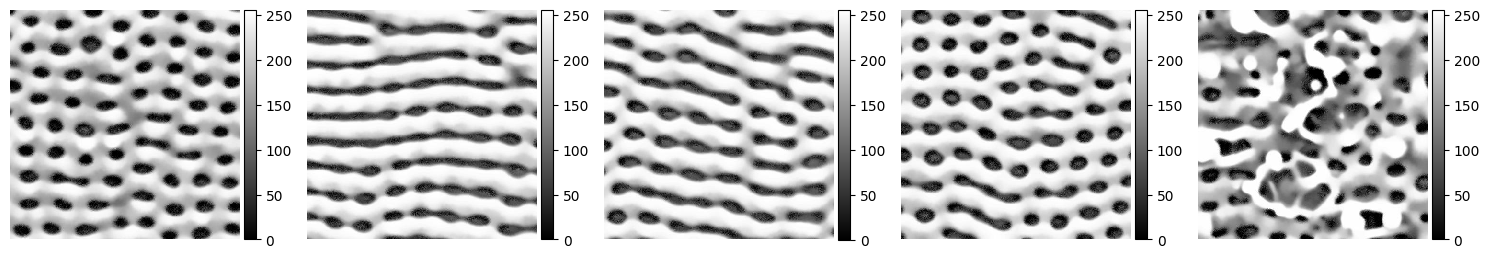

In [6]:
# We can visualize some of the data from the first set (trajectory 24_30)
nb_vis = 5
# Choose nb_vis sample indexes
idx = np.random.choice(data_set_24_30.shape[0], nb_vis, replace=False)
example_digits = [f for f in data_set_24_30[idx, ...]]
# Plot some examples
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [7]:
# Basic normalization step to be in range [0 - 1]

x_24_30 = np.expand_dims(data_set_24_30.astype('float32')/255, -1)
x_22_30 = np.expand_dims(data_set_22_30.astype('float32')/255, -1)
x_20_2  = np.expand_dims(data_set_20_2.astype('float32')/255, -1)

In [8]:
# Finally, we define the train, val and test set for each trajectory

X_train_24_30, X_test_24_30 = train_test_split(x_24_30, test_size=0.1, random_state=42)
X_test_24_30, X_eval_24_30 = train_test_split(X_test_24_30, test_size=0.5, random_state=42)

X_train_22_30, X_test_22_30 = train_test_split(x_22_30, test_size=0.1, random_state=42)
X_test_22_30, X_eval_22_30 = train_test_split(X_test_22_30, test_size=0.5, random_state=42)

X_train_20_2, X_test_20_2 = train_test_split(x_20_2, test_size=0.1, random_state=42)
X_test_20_2, X_eval_20_2 = train_test_split(X_test_20_2, test_size=0.5, random_state=42)

print('< -------- // -------- >')
print(f'Shape of 24_30 training data: {X_train_24_30.shape}, eval data: {X_eval_24_30.shape}, and test data: {X_test_24_30.shape}')
print(f'Shape of 22_30 training data: {X_train_22_30.shape}, eval data: {X_eval_22_30.shape}, and test data: {X_test_22_30.shape}')
print(f'Shape of 20_2 training data: {X_train_20_2.shape}, eval data: {X_eval_20_2.shape}, and test data: {X_test_20_2.shape}')

< -------- // -------- >
Shape of 24_30 training data: (514, 480, 480, 1), eval data: (29, 480, 480, 1), and test data: (29, 480, 480, 1)
Shape of 22_30 training data: (604, 480, 480, 1), eval data: (34, 480, 480, 1), and test data: (34, 480, 480, 1)
Shape of 20_2 training data: (288, 480, 480, 1), eval data: (16, 480, 480, 1), and test data: (16, 480, 480, 1)


-----------------------------------------------

In [9]:
def encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs

    # Example convolutional layers
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

    # Shape information for the decoder
    shape = K.int_shape(x)
    print(f"Shape of latent space: {shape}")

    # Generate latent vector Q(z|X)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Encoder model
    encoder = Model(inputs, [z_mean, z_log_var], name='encoder')
    return encoder, shape

In [10]:
def decoder(shape, latent_dim):
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    # Example convolutional transpose layers
    x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = Conv2DTranspose(1, 3, activation='sigmoid', padding='same', name='decoder_output')(x)

    # Decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder

In [11]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
input_shape = (480, 480, 1)
latent_dim = 48

# Build the encoder and decoder
encoder, shape = encoder(input_shape, latent_dim)
decoder = decoder(shape, latent_dim)

# Define VAE model
inputs = Input(shape=input_shape, name='VAE_input')
z_mean, z_log_var = encoder(inputs)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
reconstruction = decoder(z)

Shape of latent space: (None, 120, 120, 64)


In [13]:
class DisentangledVAELossLayer(tf.keras.layers.Layer):
    def __init__(self, encoder, beta=1.0, **kwargs):
        super(DisentangledVAELossLayer, self).__init__(**kwargs)
        self.encoder = encoder
        self.beta = beta

    def call(self, inputs):
        x, x_decoded = inputs
        z_mean, z_log_var = self.encoder(x)

        reconstruction_loss = binary_crossentropy(K.flatten(x), K.flatten(x_decoded))
        reconstruction_loss *= input_shape[0] * input_shape[1]

        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(K.clip(z_log_var, -100, 100))
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5 * self.beta

        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)

        return x_decoded

# Create Disentangled VAE model
beta_value = 10.0
vae_outputs = DisentangledVAELossLayer(encoder, beta_value)([inputs, reconstruction])
vae = Model(inputs, vae_outputs, name='vae')

# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
vae.compile(optimizer=optimizer)

In [14]:
# We define the callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=7, mode='min', verbose=1)

In [15]:
# Train the model
vae.fit(X_train_24_30, X_train_24_30, epochs=25, batch_size=32, validation_data=(X_eval_24_30, X_eval_24_30))

Epoch 1/25
17/17 [==============================] - 32s 748ms/step - loss: 159555.2656 - val_loss: 159353.5938
Epoch 2/25
17/17 [==============================] - 7s 384ms/step - loss: 159224.8750 - val_loss: 158855.4062
Epoch 3/25
17/17 [==============================] - 7s 399ms/step - loss: 158655.7812 - val_loss: 158075.7812
Epoch 4/25
17/17 [==============================] - 7s 389ms/step - loss: 157866.8906 - val_loss: 156962.1094
Epoch 5/25
17/17 [==============================] - 7s 392ms/step - loss: 156608.6875 - val_loss: 155520.7812
Epoch 6/25
17/17 [==============================] - 7s 395ms/step - loss: 155280.4844 - val_loss: 153941.5312
Epoch 7/25
17/17 [==============================] - 7s 410ms/step - loss: 153809.4375 - val_loss: 152805.9375
Epoch 8/25
17/17 [==============================] - 7s 396ms/step - loss: 153246.4688 - val_loss: 152113.5312
Epoch 9/25
17/17 [==============================] - 7s 405ms/step - loss: 153040.6719 - val_loss: 151991.2344
Epoch 10/

In [16]:
def create_mask(image, mask_size=(150,150), mask_location=(96,96)):
    """Creates a square mask of given size at given location on the image."""
    masked_image = np.copy(image)
    x, y = mask_location
    w, h = mask_size
    masked_image[x:x+w, y:y+h, :] = 0
    return masked_image


def generate_test_images(data, predictions, n_generate=3, mask_size=(150, 150), mask_location=(96, 96)):
    """Generates and plots original, masked, and inpainted images."""

    num_images = data.shape[0]

    # Create masked samples and their corresponding masks
    masked_samples = []
    masks = []
    for img in data:
        masked_img = create_mask(img, mask_size, mask_location)
        masked_samples.append(masked_img)

        # Create a mask: 1 where the image is masked, 0 otherwise
        mask = np.zeros_like(img[:, :, 0], dtype=np.float32)
        x, y = mask_location
        w, h = mask_size
        mask[x:x+w, y:y+h] = 1
        masks.append(mask)

    masked_samples = np.array(masked_samples)
    masks = np.array(masks)

    fig, axes = plt.subplots(nrows=n_generate, ncols=3, figsize=(12, 6))

    # Metrics calculations
    ssim_values = []
    psnr_values = []

    for i in range(num_images):
        # Calculate SSIM and PSNR
        inpainted_image = data[i, :, :, 0] * (1 - masks[i]) + predictions[i, :, :, 0] * masks[i]

        # Convert to arrays for SSIM and PSNR calculation
        inpainted_image = data[i, :, :, 0] * (1 - masks[i]) + predictions[i, :, :, 0]* masks[i]

        current_ssim = ssim(data[i, :, :, 0], inpainted_image, data_range=inpainted_image.max() - inpainted_image.min())
        current_psnr = psnr(data[i, :, :, 0], inpainted_image, data_range=inpainted_image.max() - inpainted_image.min())

        ssim_values.append(current_ssim)
        psnr_values.append(current_psnr)

        if i < n_generate:
            # Original image
            axes[i, 0].imshow(data[i, :, :, 0], cmap='gray')
            axes[i, 0].set_title("Original")
            axes[i, 0].axis('off')

            # Masked image
            axes[i, 1].imshow(masked_samples[i, :, :, 0], cmap='gray')
            axes[i, 1].set_title("Masked")
            axes[i, 1].axis('off')

            # Inpainted image
            inpainted_image = data[i, :, :, 0] * (1 - masks[i]) + predictions[i, :, :, 0] * masks[i]
            axes[i, 2].imshow(inpainted_image, cmap='gray')
            axes[i, 2].set_title("Inpainted")
            axes[i, 2].axis('off')

    # Print average SSIM and PSNR for the batch
    print(f"Average SSIM: {np.mean(ssim_values)}, Average PSNR: {np.mean(psnr_values)}")

    plt.tight_layout()
    plt.show()

Average SSIM: 0.9371270431764233, Average PSNR: 20.962624215896508


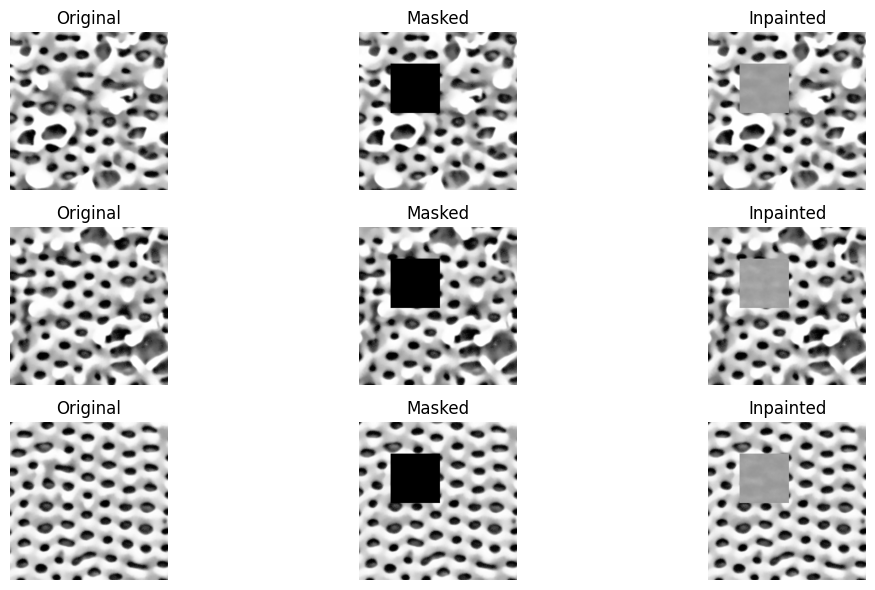

In [17]:
# We get the predictions for the test set
predicted_images = vae.predict(X_test_24_30, verbose=0)
generate_test_images(X_test_24_30, predicted_images, n_generate=3)

Epoch 1/25
19/19 [==============================] - 21s 948ms/step - loss: 138027.0156 - val_loss: 131534.6562
Epoch 2/25
19/19 [==============================] - 9s 449ms/step - loss: 134764.9531 - val_loss: 128261.3438
Epoch 3/25
19/19 [==============================] - 9s 453ms/step - loss: 133824.3750 - val_loss: 127638.1562
Epoch 4/25
19/19 [==============================] - 9s 457ms/step - loss: 133585.6562 - val_loss: 127364.4375
Epoch 5/25
19/19 [==============================] - 9s 449ms/step - loss: 133521.0000 - val_loss: 127962.5391
Epoch 6/25
19/19 [==============================] - 8s 440ms/step - loss: 133426.0781 - val_loss: 128132.8359
Epoch 7/25
19/19 [==============================] - 8s 443ms/step - loss: 133386.5781 - val_loss: 127010.8672
Epoch 8/25
19/19 [==============================] - 8s 436ms/step - loss: 133391.4375 - val_loss: 127290.6719
Epoch 9/25
19/19 [==============================] - 8s 448ms/step - loss: 133261.0781 - val_loss: 127240.8125
Epoch 10/

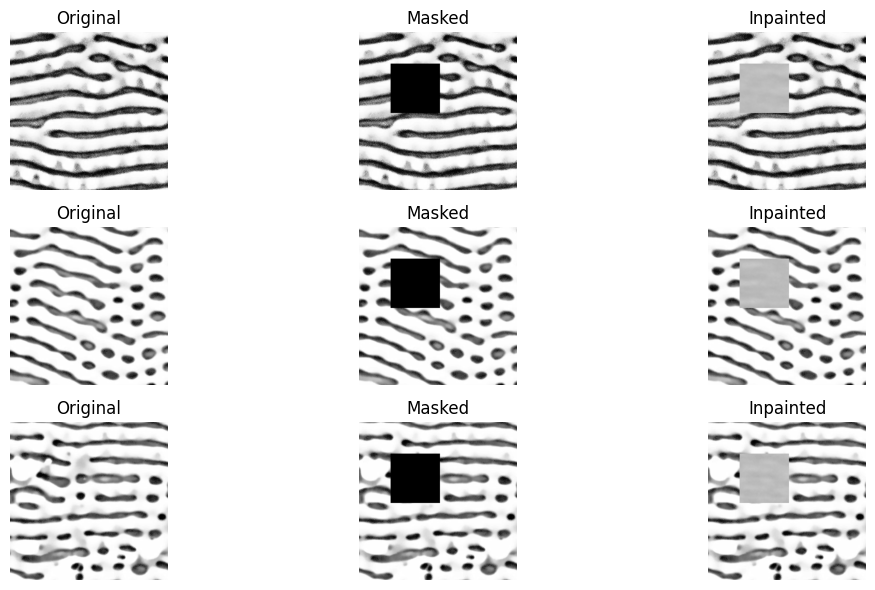

In [18]:
# Now, for trajectory 22_30

vae = Model(inputs, vae_outputs, name='vae')

# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
vae.compile(optimizer=optimizer)

# Train the model
vae.fit(X_train_22_30, X_train_22_30, epochs=25, batch_size=32, validation_data=(X_eval_22_30, X_eval_22_30))

# We get the predictions for the test set
predicted_images = vae.predict(X_test_22_30, verbose=0)
generate_test_images(X_test_22_30, predicted_images, n_generate=3)

Epoch 1/25
9/9 [==============================] - 10s 840ms/step - loss: 162757.3438 - val_loss: 161996.6562
Epoch 2/25
9/9 [==============================] - 4s 447ms/step - loss: 159402.8906 - val_loss: 158779.9688
Epoch 3/25
9/9 [==============================] - 4s 449ms/step - loss: 157134.6875 - val_loss: 157118.3438
Epoch 4/25
9/9 [==============================] - 4s 452ms/step - loss: 155799.3750 - val_loss: 156127.2656
Epoch 5/25
9/9 [==============================] - 4s 459ms/step - loss: 155089.9219 - val_loss: 155540.4219
Epoch 6/25
9/9 [==============================] - 4s 465ms/step - loss: 154830.2188 - val_loss: 155374.3125
Epoch 7/25
9/9 [==============================] - 4s 462ms/step - loss: 154787.0156 - val_loss: 155322.7188
Epoch 8/25
9/9 [==============================] - 4s 458ms/step - loss: 154762.9844 - val_loss: 155318.5625
Epoch 9/25
9/9 [==============================] - 4s 452ms/step - loss: 154750.7188 - val_loss: 155318.9844
Epoch 10/25
9/9 [==========

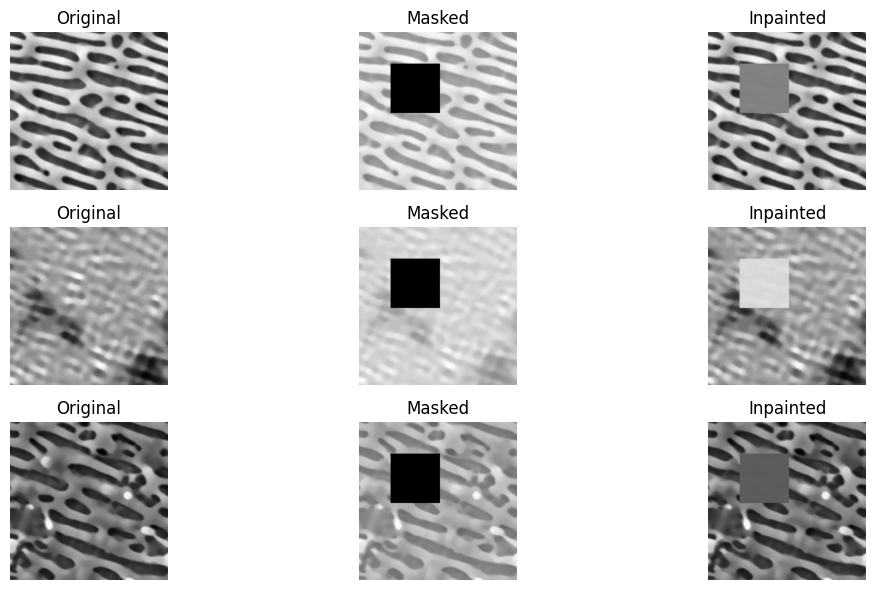

In [19]:
# Now, for trajectory 20_2

vae = Model(inputs, vae_outputs, name='vae')

# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
vae.compile(optimizer=optimizer)

# Train the model
vae.fit(X_train_20_2, X_train_20_2, epochs=25, batch_size=32, validation_data=(X_eval_20_2, X_eval_20_2))

# We get the predictions for the test set
predicted_images = vae.predict(X_test_20_2, verbose=0)
generate_test_images(X_test_20_2, predicted_images, n_generate=3)

### Now, let's change the beta regularization value to something low, favoring the reconstruction error

Epoch 1/25
17/17 [==============================] - 12s 443ms/step - loss: 153129.9062 - val_loss: 151609.0312
Epoch 2/25
17/17 [==============================] - 7s 431ms/step - loss: 152606.4375 - val_loss: 151573.9844
Epoch 3/25
17/17 [==============================] - 7s 435ms/step - loss: 152695.8281 - val_loss: 151594.3750
Epoch 4/25
17/17 [==============================] - 7s 438ms/step - loss: 153563.2188 - val_loss: 151642.8594
Epoch 5/25
17/17 [==============================] - 7s 433ms/step - loss: 153326.5938 - val_loss: 151607.0625
Epoch 6/25
17/17 [==============================] - 7s 435ms/step - loss: 152479.4375 - val_loss: 151636.4531
Epoch 7/25
17/17 [==============================] - 7s 426ms/step - loss: 153716.0000 - val_loss: 151604.1250
Epoch 8/25
17/17 [==============================] - 7s 425ms/step - loss: 152659.0156 - val_loss: 151638.7188
Epoch 9/25
17/17 [==============================] - 7s 417ms/step - loss: 152462.3750 - val_loss: 151559.4844
Epoch 10/

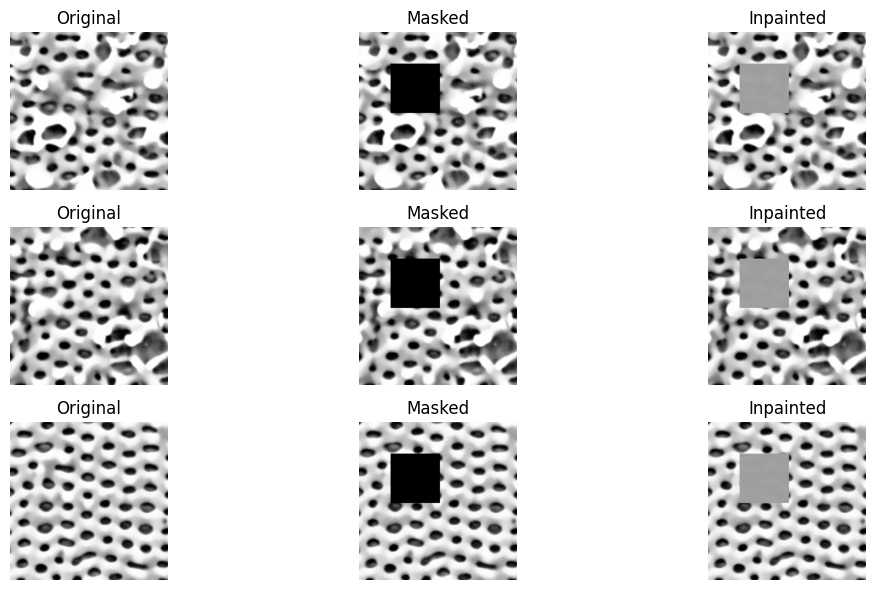

In [20]:
# Create Disentangled VAE model
beta_value = 0.2
vae_outputs = DisentangledVAELossLayer(encoder, beta_value)([inputs, reconstruction])
vae = Model(inputs, vae_outputs, name='vae')

# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
vae.compile(optimizer=optimizer)

# Train the model
vae.fit(X_train_24_30, X_train_24_30, epochs=25, batch_size=32, validation_data=(X_eval_24_30, X_eval_24_30))

# We get the predictions for the test set
predicted_images = vae.predict(X_test_24_30, verbose=0)
generate_test_images(X_test_24_30, predicted_images, n_generate=3)

Epoch 1/25
19/19 [==============================] - 12s 466ms/step - loss: 137576.7969 - val_loss: 130956.0312
Epoch 2/25
19/19 [==============================] - 9s 452ms/step - loss: 134218.7969 - val_loss: 127788.8203
Epoch 3/25
19/19 [==============================] - 9s 455ms/step - loss: 133463.4062 - val_loss: 126792.9453
Epoch 4/25
19/19 [==============================] - 8s 447ms/step - loss: 133226.1250 - val_loss: 127667.8125
Epoch 5/25
19/19 [==============================] - 9s 449ms/step - loss: 133227.6250 - val_loss: 126869.8672
Epoch 6/25
19/19 [==============================] - 8s 441ms/step - loss: 133211.8438 - val_loss: 127050.3906
Epoch 7/25
19/19 [==============================] - 9s 449ms/step - loss: 133155.3750 - val_loss: 127028.9531
Epoch 8/25
19/19 [==============================] - 9s 453ms/step - loss: 133123.0625 - val_loss: 126903.1562
Epoch 9/25
19/19 [==============================] - 8s 448ms/step - loss: 133092.7656 - val_loss: 127251.4375
Epoch 10/

Average SSIM: 0.9312099990346115, Average PSNR: 21.24849935237496


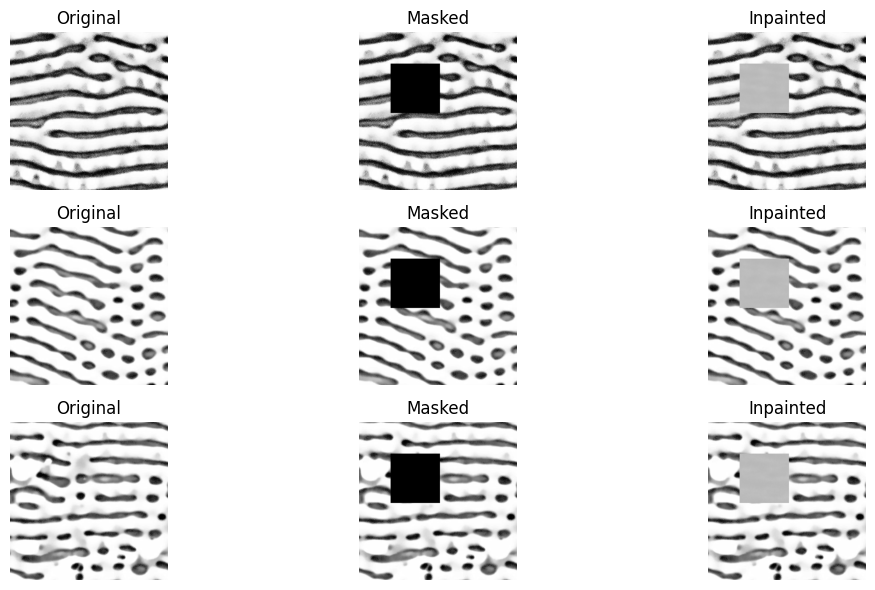

In [21]:
# Now, for trajectory 22_30

vae = Model(inputs, vae_outputs, name='vae')

# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
vae.compile(optimizer=optimizer)

# Train the model
vae.fit(X_train_22_30, X_train_22_30, epochs=25, batch_size=32, validation_data=(X_eval_22_30, X_eval_22_30))

# We get the predictions for the test set
predicted_images = vae.predict(X_test_22_30, verbose=0)
generate_test_images(X_test_22_30, predicted_images, n_generate=3)

Epoch 1/25
9/9 [==============================] - 8s 474ms/step - loss: 162187.7188 - val_loss: 161410.8594
Epoch 2/25
9/9 [==============================] - 4s 456ms/step - loss: 159013.2969 - val_loss: 158731.1406
Epoch 3/25
9/9 [==============================] - 4s 463ms/step - loss: 156932.5000 - val_loss: 156970.9688
Epoch 4/25
9/9 [==============================] - 4s 449ms/step - loss: 155675.8438 - val_loss: 155968.3125
Epoch 5/25
9/9 [==============================] - 4s 455ms/step - loss: 155023.8906 - val_loss: 155421.0781
Epoch 6/25
9/9 [==============================] - 4s 472ms/step - loss: 154807.9688 - val_loss: 155342.0625
Epoch 7/25
9/9 [==============================] - 4s 461ms/step - loss: 154824.1719 - val_loss: 155320.5000
Epoch 8/25
9/9 [==============================] - 4s 452ms/step - loss: 154785.6406 - val_loss: 155320.2656
Epoch 9/25
9/9 [==============================] - 4s 450ms/step - loss: 154760.1719 - val_loss: 155315.7188
Epoch 10/25
9/9 [===========

Average SSIM: 0.9445339832518638, Average PSNR: 23.25558898403606


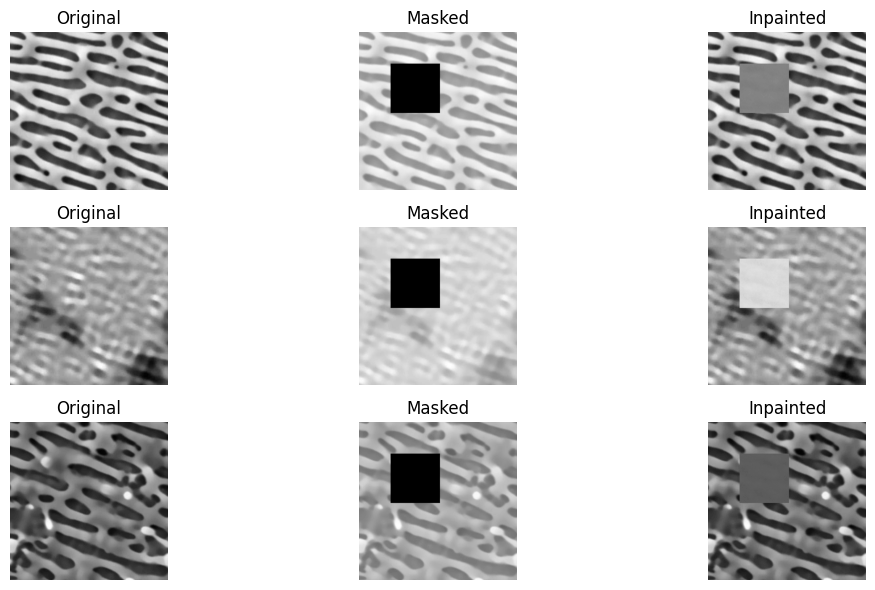

In [22]:
# Now, for trajectory 20_2

vae = Model(inputs, vae_outputs, name='vae')

# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
vae.compile(optimizer=optimizer)

# Train the model
vae.fit(X_train_20_2, X_train_20_2, epochs=25, batch_size=32, validation_data=(X_eval_20_2, X_eval_20_2))

# We get the predictions for the test set
predicted_images = vae.predict(X_test_20_2, verbose=0)
generate_test_images(X_test_20_2, predicted_images, n_generate=3)

Epoch 1/25
17/17 [==============================] - 10s 420ms/step - loss: 152984.3281 - val_loss: 151520.0625
Epoch 2/25
17/17 [==============================] - 7s 407ms/step - loss: 153124.6094 - val_loss: 151562.7656
Epoch 3/25
17/17 [==============================] - 7s 411ms/step - loss: 152699.3281 - val_loss: 151578.1719
Epoch 4/25
17/17 [==============================] - 7s 424ms/step - loss: 152976.6094 - val_loss: 151526.4062
Epoch 5/25
17/17 [==============================] - 7s 414ms/step - loss: 152738.7969 - val_loss: 151502.8594
Epoch 6/25
17/17 [==============================] - 7s 421ms/step - loss: 152645.4688 - val_loss: 151531.5938
Epoch 7/25
17/17 [==============================] - 7s 423ms/step - loss: 153163.1875 - val_loss: 151617.0000
Epoch 8/25
17/17 [==============================] - 7s 430ms/step - loss: 153329.3750 - val_loss: 151552.0469
Epoch 9/25
17/17 [==============================] - 7s 439ms/step - loss: 152853.1875 - val_loss: 151554.1094
Epoch 10/

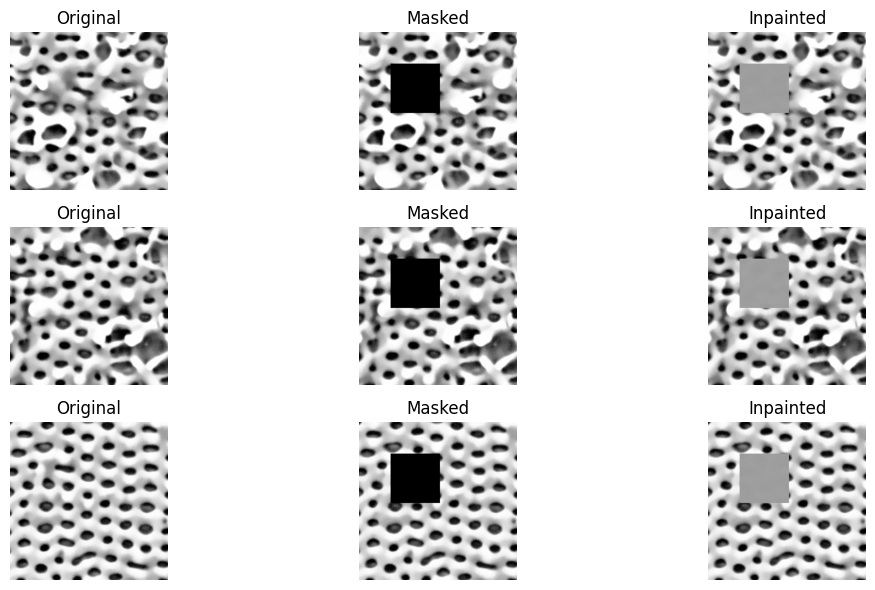

In [24]:
# Create Disentangled VAE model
beta_value = 35
vae_outputs = DisentangledVAELossLayer(encoder, beta_value)([inputs, reconstruction])
vae = Model(inputs, vae_outputs, name='vae')

# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
vae.compile(optimizer=optimizer)

# Train the model
vae.fit(X_train_24_30, X_train_24_30, epochs=25, batch_size=32, validation_data=(X_eval_24_30, X_eval_24_30))

# We get the predictions for the test set
predicted_images = vae.predict(X_test_24_30, verbose=0)
generate_test_images(X_test_24_30, predicted_images, n_generate=3)

Epoch 1/25
19/19 [==============================] - 12s 469ms/step - loss: 138076.1250 - val_loss: 131944.4219
Epoch 2/25
19/19 [==============================] - 9s 451ms/step - loss: 134433.7969 - val_loss: 127849.9062
Epoch 3/25
19/19 [==============================] - 9s 450ms/step - loss: 133176.3281 - val_loss: 126826.7188
Epoch 4/25
19/19 [==============================] - 9s 453ms/step - loss: 133093.0469 - val_loss: 126927.2656
Epoch 5/25
19/19 [==============================] - 9s 455ms/step - loss: 133083.1406 - val_loss: 126597.7500
Epoch 6/25
19/19 [==============================] - 8s 444ms/step - loss: 133074.1094 - val_loss: 126850.6719
Epoch 7/25
19/19 [==============================] - 8s 441ms/step - loss: 133067.1250 - val_loss: 126735.6719
Epoch 8/25
19/19 [==============================] - 8s 438ms/step - loss: 133079.6875 - val_loss: 127132.1094
Epoch 9/25
19/19 [==============================] - 9s 449ms/step - loss: 133110.3438 - val_loss: 126764.7031
Epoch 10/

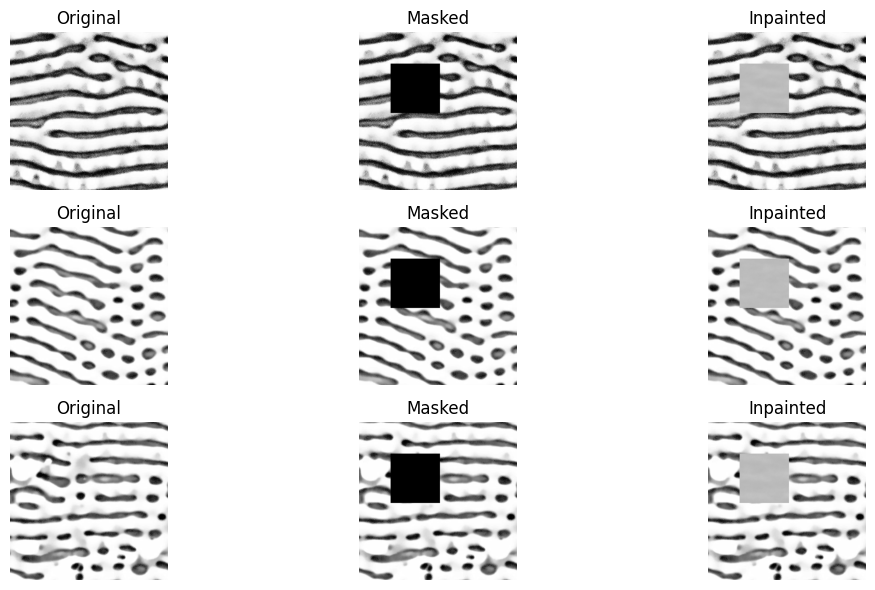

In [25]:
# Now, for trajectory 22_30

vae = Model(inputs, vae_outputs, name='vae')

# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
vae.compile(optimizer=optimizer)

# Train the model
vae.fit(X_train_22_30, X_train_22_30, epochs=25, batch_size=32, validation_data=(X_eval_22_30, X_eval_22_30))

# We get the predictions for the test set
predicted_images = vae.predict(X_test_22_30, verbose=0)
generate_test_images(X_test_22_30, predicted_images, n_generate=3)

Epoch 1/25
9/9 [==============================] - 8s 468ms/step - loss: 162108.2656 - val_loss: 161375.0938
Epoch 2/25
9/9 [==============================] - 4s 439ms/step - loss: 158985.6719 - val_loss: 158663.6406
Epoch 3/25
9/9 [==============================] - 4s 446ms/step - loss: 156917.8281 - val_loss: 156954.2656
Epoch 4/25
9/9 [==============================] - 4s 451ms/step - loss: 155640.9375 - val_loss: 155915.7969
Epoch 5/25
9/9 [==============================] - 4s 442ms/step - loss: 154987.0625 - val_loss: 155449.7188
Epoch 6/25
9/9 [==============================] - 4s 454ms/step - loss: 154816.2812 - val_loss: 155339.7812
Epoch 7/25
9/9 [==============================] - 4s 448ms/step - loss: 154797.3125 - val_loss: 155314.2500
Epoch 8/25
9/9 [==============================] - 4s 456ms/step - loss: 154772.3594 - val_loss: 155325.8750
Epoch 9/25
9/9 [==============================] - 4s 460ms/step - loss: 154758.8906 - val_loss: 155323.8125
Epoch 10/25
9/9 [===========

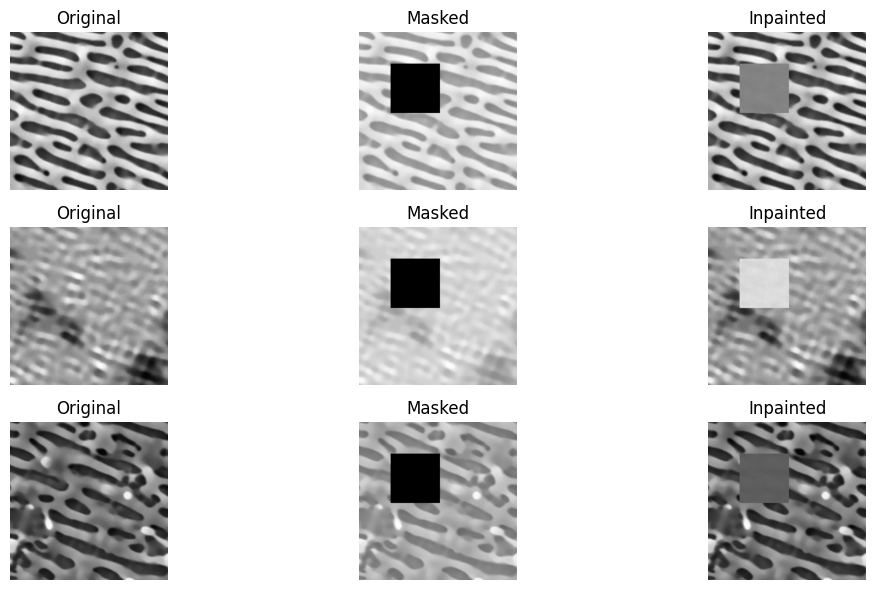

In [26]:
# Now, for trajectory 20_2

vae = Model(inputs, vae_outputs, name='vae')

# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
vae.compile(optimizer=optimizer)

# Train the model
vae.fit(X_train_20_2, X_train_20_2, epochs=25, batch_size=32, validation_data=(X_eval_20_2, X_eval_20_2))

# We get the predictions for the test set
predicted_images = vae.predict(X_test_20_2, verbose=0)
generate_test_images(X_test_20_2, predicted_images, n_generate=3)

In [23]:
# End of notebook!